In [ ]:
import os
import zipfile
import requests

url = "https://www.kaggle.com/api/v1/datasets/download/msambare/fer2013"
output_path = "./fer2013.zip"

response = requests.get(url, allow_redirects=True)
response.raise_for_status()

with open(output_path, 'wb') as f:
    f.write(response.content)

os.mkdir('fer2013')
with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall('./fer2013')

In [ ]:
import torch
from typing import Any, Dict
from torchvision.transforms import v2

import random
from torchvision.transforms import functional as F

class RandomImageFlip(torch.nn.Module):
    def __init__(self, horizontalPercent: float = 0.5):
        super().__init__()
        self.p = horizontalPercent

    def forward(self, img):
        if random.random() < self.p:
            return F.hflip(img)
        else:
            return F.vflip(img)

class RandomDistortion(torch.nn.Module):
    def __init__(self, p: float, kernel_size: int, noise_amplitude: float):
        super().__init__()
        self.p = p
        self.kernel_size = kernel_size
        self.noise_amplitude = noise_amplitude

    def forward(self, img):
        if random.random() < self.p:
            return F.gaussian_blur(img, kernel_size=self.kernel_size)
        else:
            noise = (torch.rand_like(img) - 0.5) * 2 * self.noise_amplitude
            return torch.clamp(img + noise, 0.0, 1.0)

In [ ]:
import numpy as np
from pathlib import Path
from torchvision import datasets

base_transform = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.Resize((48, 48)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

augment_transform = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.Resize((48, 48)),
    RandomImageFlip(horizontalPercent=0.5), # 50% chance to flip horizontally or vertically,
    v2.RandomRotation(degrees=45, interpolation=v2.InterpolationMode.BILINEAR), # Bilinear interpolation to have smoother edges
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    RandomDistortion(p=0.5, kernel_size=3, noise_amplitude=0.1), # 50% chance to apply Gaussian blur or add noise
])

data_dir = Path("./fer2013")

train_dataset = datasets.ImageFolder(root=data_dir / "train", transform=base_transform)
test_dataset = datasets.ImageFolder(root=data_dir / "test", transform=base_transform)

train_dataset_aug = datasets.ImageFolder(root=data_dir / "train", transform=augment_transform)

concatenated_train_dataset = torch.utils.data.ConcatDataset([train_dataset, train_dataset_aug])

train_loader = torch.utils.data.DataLoader(concatenated_train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train dataset:")
for c in train_dataset.classes:
    c_idx = train_dataset.class_to_idx[c]
    count = np.count_nonzero(np.array(train_dataset.targets) == c_idx)
    count_aug = np.count_nonzero(np.array(train_dataset_aug.targets) == c_idx)
    print(f"\tLoaded {count:<5} samples of {c:<8}({c_idx}) | With Augmentation: {count + count_aug}")

print(f"Test dataset:")
for c in test_dataset.classes:
    c_idx = test_dataset.class_to_idx[c]
    count = np.count_nonzero(np.array(test_dataset.targets) == c_idx)
    print(f"\tLoaded {count:<5} samples of {c:<8}({c_idx})")

Train dataset:
	Loaded 3995  samples of angry   (0) | With Augmentation: 7990
	Loaded 436   samples of disgust (1) | With Augmentation: 872
	Loaded 4097  samples of fear    (2) | With Augmentation: 8194
	Loaded 7215  samples of happy   (3) | With Augmentation: 14430
	Loaded 4965  samples of neutral (4) | With Augmentation: 9930
	Loaded 4830  samples of sad     (5) | With Augmentation: 9660
	Loaded 3171  samples of surprise(6) | With Augmentation: 6342
Test dataset:
	Loaded 958   samples of angry   (0)
	Loaded 111   samples of disgust (1)
	Loaded 1024  samples of fear    (2)
	Loaded 1774  samples of happy   (3)
	Loaded 1233  samples of neutral (4)
	Loaded 1247  samples of sad     (5)
	Loaded 831   samples of surprise(6)


Visualizing 5 samples from the dataset:


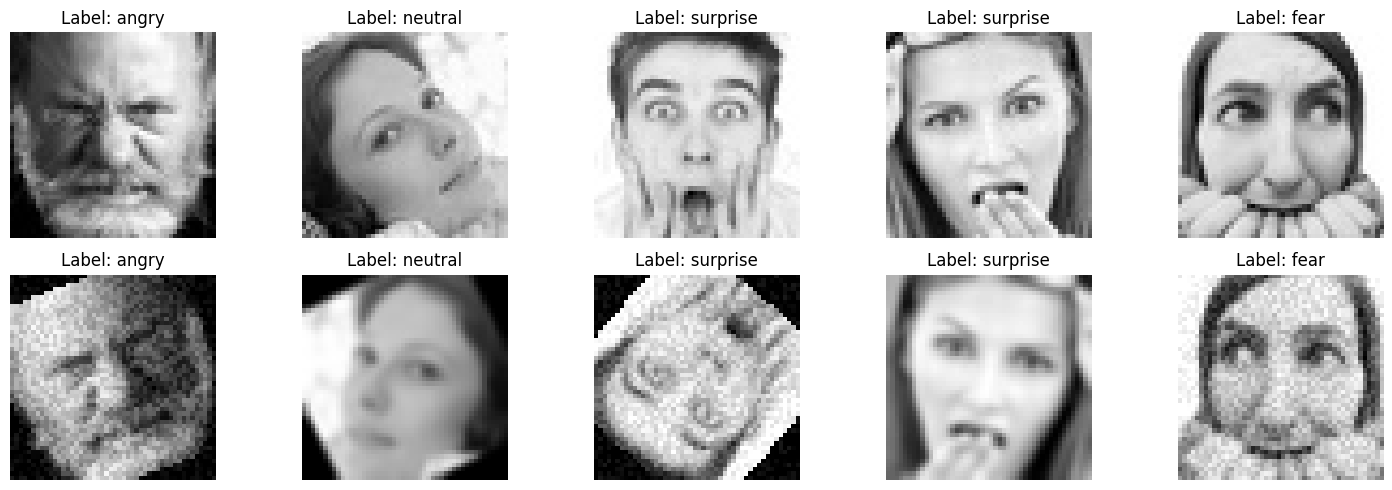

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_dataset(old_dataset, new_dataset, num_samples=5):
    print(f"Visualizing {num_samples} samples from the dataset:")
    random_indices = np.random.choice(len(new_dataset), num_samples, replace=False)

    _, axes = plt.subplots(2, num_samples, figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        # Before
        image, label = old_dataset[idx]
        image = image.permute(1, 2, 0).numpy()
        image = (image * 255).astype(np.uint8)
        image = image.squeeze(axis=2)
        
        axes[0][i].imshow(image, cmap='gray')
        axes[0][i].set_title(f"Label: {old_dataset.classes[label]}")
        axes[0][i].axis('off')
        
        # After
        image, label = new_dataset[idx]
        image = image.permute(1, 2, 0).numpy()
        image = (image * 255).astype(np.uint8)
        image = image.squeeze(axis=2)

        axes[1][i].imshow(image, cmap='gray')
        axes[1][i].set_title(f"Label: {new_dataset.classes[label]}")
        axes[1][i].axis('off')
    plt.tight_layout()
    plt.show()

visualize_dataset(train_dataset, train_dataset_aug, 5)

In [ ]:
concatenated_train_dataset

NameError: name 'concatenated_train_dataset' is not defined